Switching device to CPU.
Loading Vision Model...
Model loaded successfully.

0: 800x1024 5 grade headerss, 6 grade tables, 5 singe row tables, 46.0ms
Speed: 7.7ms preprocess, 46.0ms inference, 1818.9ms postprocess per image at shape (1, 3, 800, 1024)
Image path: c:\Users\Declan Bracken\Pictures\Saved Pictures\2015-queens-university-transcript-1-2048.webp


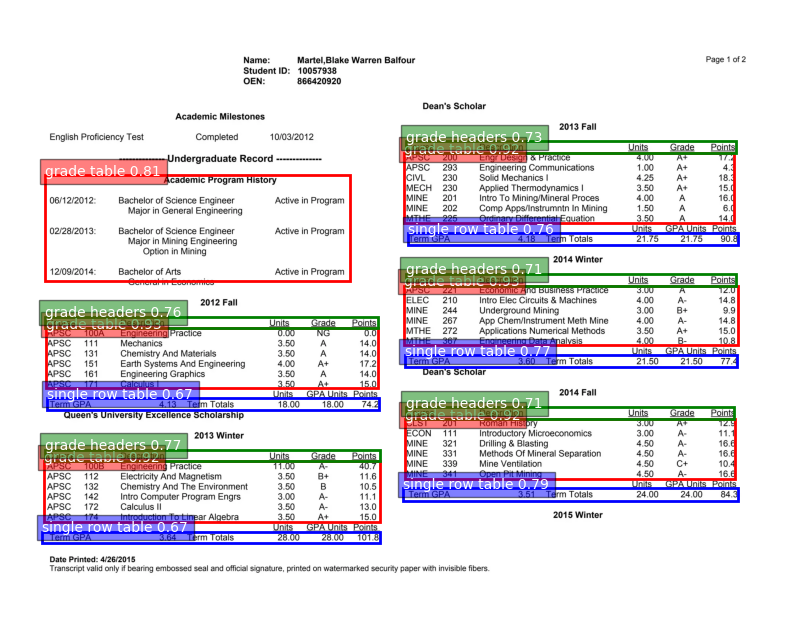

In [2]:
import sys

# Manually specify the path to the parent directory
parent_dir = r'c:\Users\Declan Bracken\MEng_Project'  # Replace this with the path where 'Pipelines' is located
sys.path.append(parent_dir)

# Import vision_pipeline from Pipelines
from Pipelines.Py_files.vision_pipeline import VisionPipeline

# Step 1: Import Classes
from image_processor import ImageProcessor
from text_classifier import TextClassifier
from row_clusterer_v2 import RowClassifier
from clustering_gui_jupyter import InteractiveClusterTuning
from column_clusterer import ColumnClusterer#, ColumnClustererV2
from dataframe_processor import DataFrameProcessor

# Step 2: Load Example Image and Model Results
# image_directory = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Web_Scraped_Transcripts/'
# image_name = '2015-queens-university-transcript-1-2048.webp'
# image_path = image_directory + image_name
# image_path = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Web_Scraped_Transcripts/bachelors-degree-transcript-2-2048-1.webp'
# image_path = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Web_Scraped_Transcripts/kayla-martin-unofficial-transcript-unlocked-1-2048.webp'
# image_path = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Web_Scraped_Transcripts/transcript-1-3-2048-1.webp' # test transcript
# image_path = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Web_Scraped_Transcripts/transcript-1-2048-1.webp' # test transcript
# image_path = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Web_Scraped_Transcripts/ba-transcript-3-2048.webp'
# image_path = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Test transcripts/transcripts-2-2048.png'
# image_path = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Web_Scraped_Transcripts/up-academic-record-1-2048.webp'
#Real Transcript
# image_path = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Real Transcripts/7.JPG'
# image_path = '/Users/declanbracken/Development/UofT_Projects/Meng_Project/Transcripts/Real Transcripts/5.png'

image_path = r'c:\Users\Declan Bracken\Pictures\Saved Pictures\2015-queens-university-transcript-1-2048.webp'
model_path =  r'C:\Users\Declan Bracken\MEng_Project\yolo_training\yolo_v8_models\finetune_v4 (3_classes)\best (1).pt'

pipeline = VisionPipeline(model_path)
results = pipeline.predict(image_path, plot = True, iou = 0.3, conf = 0.5, agnostic_nms = True)


In [3]:
boxes = results[0].boxes.data.cpu().numpy()
classes = results[0].boxes.cls.cpu().numpy()
# Step 3: Initialize ImageProcessor and Check Cropped Images
image_processor = ImageProcessor(image_path, boxes)
cropped_images = image_processor.cropped_images
print(f"Number of cropped images: {len(cropped_images)}")
# Step 4: Initialize TextClassifier and Classify Text
text_classifier = TextClassifier(cropped_images, classes, boxes)


Number of cropped images: 16


In [6]:
text_classifier.headers[1]['text']['text']

['', '', '', '', 'Course', 'Description', 'Units', 'Grade', 'Points']

In [9]:
"""Note
THRESHOLD around ~0.5-0.55 works well for typical row grouping when all lines have multiple words.
THRESHOLD around ~0.25-0.35 works well for transcripts with several lines having few words.
"""
# Step 5: Initialize RowClassifier and Cluster Rows
row_classifier = RowClassifier(text_classifier.headers, text_classifier.single_row, text_classifier.tables)

# Seperate by Rows
all_rows = row_classifier.collect_all_rows()
print("Number of rows for clustering:", len(all_rows))

# Optimize distance threshold
best_threshold = row_classifier.optimize_by_histogram(all_rows)

image = image_processor.image
gui = InteractiveClusterTuning(image, row_classifier, all_rows, best_threshold = best_threshold)


Number of rows for clustering: 43


FloatSlider(value=0.5026440071556351, description='Lower <-  Segmentation  -> Greater:', max=0.8, min=0.1, ste…

Button(description='Recalculate', style=ButtonStyle())

Output()

In [9]:
import numpy as np
import pandas as pd

grouped_data = gui.grouped_data
# Step 6: Initialize ColumnClusterer and Cluster Columns for each table
column_clusterer = ColumnClusterer(grouped_data)
tables_data = column_clusterer.all_tables_data
all_tables_dfs = []

for table_data in tables_data:

            positions = table_data['positions']
            texts = table_data['texts']
            line_numbers = table_data['line_numbers']

            num_lines = len(set(line_numbers))

            # Check for more than one word per row:
            has_columns = len(line_numbers) != num_lines

            if has_columns and num_lines > 1:
                labels = column_clusterer.perform_hdbscan_clustering(positions, min_cluster_size = num_lines, min_samples = 5)
                labels = column_clusterer.reorder_columns(labels, positions)
                # labels = column_clusterer.perform_clustering(positions, optimal_eps)
                num_cols = len(set(labels))
            elif num_lines > 1: # More than one line, but one column
                labels = [0 for _ in range(num_lines)]
                num_cols = len(set(labels))
            else: # More than one column, but one line
                optimal_eps = 27.5
                labels = column_clusterer.perform_clustering(positions, optimal_eps)
                num_cols = len(set(labels))

            df = pd.DataFrame(np.nan, index=range(num_lines), columns=range(num_cols))

            for text, label, line in zip(texts, labels, line_numbers):
                
                if 0 <= label < num_cols and 0 <= line < num_lines:
                    if pd.notna(df.at[line, label]):
                        df.at[line, label] = f"{df.at[line, label]} {text}"
                    else:
                        df.at[line, label] = text
            

            df.dropna(how='all', inplace=True)
            df.reset_index(drop=True, inplace=True)
            all_tables_dfs.append(df)
    


In [15]:
grouped_data[0]

{'positions': array([[ 15,  78],
        [ 85, 135],
        [184, 232],
        [286, 360],
        [366, 425],
        [455, 503],
        [575, 624],
        [815, 863]]),
 'global_positions': array([[     92.468,      155.47],
        [     162.47,      212.47],
        [     261.47,      309.47],
        [     363.47,      437.47],
        [     443.47,      502.47],
        [     532.47,      580.47],
        [     652.47,      701.47],
        [     892.47,      940.47]]),
 'texts': ['Course',
  'Trans',
  '0.000',
  'Transfer',
  'Totals:',
  '0.000',
  '9.000',
  '0.000'],
 'y_positions': array([[ 7, 15],
        [ 7, 15],
        [ 7, 15],
        [ 7, 15],
        [ 7, 15],
        [ 7, 15],
        [ 7, 15],
        [ 7, 15]]),
 'y_global_positions': array([[     935.65,      950.65],
        [     935.65,      950.65],
        [     935.65,      950.65],
        [     935.65,      950.65],
        [     935.65,      950.65],
        [     935.65,      950.65],
        [   

In [10]:
all_tables_dfs[1]

,0,1,2,3,4,5,6
0,FIN,300,Fundamentals of,3.000,3.000,A,12.000
1,MGT,300,Org & Mgt Leadership,3.000,3.000,A,12.000
2,MUS,354,Popular Music,3.000,3.000,A,12.000
3,SCM,300,Global Supply,3.000,3.000,A,12.000
4,SWU,171,Introduction to Social,3.000,3.000,A,12.000
5,WPC,301,Business forum,1.000,1.000,At,4.333
6,ACC,231,Uses of Accounting Info,3.000,3.000,A,12.000
7,AST,111,Intro/Solar Systems,3.000,3.000,A,12.000
8,ENG,108,English for Foreign,3.000,3.000,At,12.999
9,MAT,211,Math for Business,3.000,3.000,A,12.000


In [4]:
regrouped_data = gui.regrouped_data
# Step 6: Initialize ColumnClusterer and Cluster Columns for each table
column_clusterer = ColumnClusterer(regrouped_data)
all_tables_data = column_clusterer.all_tables_data
# Step 7: Initialize DataFrameProcessor and Process Rows to DataFrame
df_processor = DataFrameProcessor()
final_dfs = df_processor.process_tables_to_dataframe(all_tables_data, column_clusterer)

In [6]:
for df in final_dfs:
    print(df.head(50))
# final_dfs[1].head(50)

             0         1            2       3     4    5        6    7     8
0   WED 258 CR      Work   Experience  18.000   NaN  NaN      NaN  NaN   NaN
1      WED & A      Trng         Prop   3.000  381A  Rpt  Writing  NaN   NaN
2    WED 382 A    Career  Development   3.000   NaN  NaN      NaN  NaN   NaN
3  WED 460 & A       NaN     Analysis   3.000   NaN  NaN      Dev  Occ  Curr
4  WED 462 & A  Instruct      Methods   3.000   NaN  NaN     Mats  NaN   NaN
    0
0  00
          0      1     2           3     4           5         6
0  Training  Inst.  5/05    - ~— (8)  5/06         NaN       NaN
1       NaN    NaN  5/03  Fire - (2)  9/03  Protection  Craftman
                 0
0  5/04 - 5/05 (8)
     0     1    2    3          4     5    6          7       8     9     10  \
0  Fall  2004  Com  Col       of U   the  Air  Force-Air     NaN   NaN   NaN   
1  Fall  2005  Com  Col       of U   the  Air  Force-Air     NaN   NaN   NaN   
2   NaN   NaN  NaN  NaN        NaN  Core  NaN        

In [22]:
# Step 5: Initialize RowClassifier and Cluster Rows
row_classifier = RowClassifier(text_classifier.headers, text_classifier.single_row, text_classifier.tables)
# Issue with ALL ROWS and PLOTTING!!
# Seperate by Rows
all_rows = row_classifier.collect_all_rows()
print("Number of rows for clustering:", len(all_rows))

# Create binary feature map
row_features = row_classifier.create_binary_heatmap_features(all_rows)
# Function here for plotting features

# Calculate the Jaccard distance matrix
distance_matrix = row_classifier.calculate_jaccard_distance_matrix(row_features)
# Optimize distance threshold
best_threshold = row_classifier.optimize_distance_threshold(row_features, distance_matrix, linkage = 'average')

# Perform Clustering Using Best Threshold
labels = row_classifier.cluster_lines_with_agglomerative_jaccard(distance_matrix, distance_threshold=best_threshold, linkage='average')

# Group rows by label
grouped_data = row_classifier.group_rows_by_labels(all_rows, labels)
# Check clustering metrics
row_classifier.check_clustering_importance(distance_matrix, labels)
print("Number of Clusters:", max(labels)+1)

print("\nRaw Feature Metrics:")
row_classifier.calculate_clustering_metrics(row_features, labels)

print("\nDistance Matrix Metrics:")
row_classifier.calculate_clustering_metrics(distance_matrix, labels)

Number of rows for clustering: 34
differential_evolution step 1: f(x)= 1.391
differential_evolution step 2: f(x)= 1.391
differential_evolution step 3: f(x)= 1.391
Polishing solution with 'L-BFGS-B'
Optimal distance threshold: 0.7054981432063925
Single Cluster WSS: 52.159917875860444
Multiple Cluster WSS: 49.57940074382853
Number of Clusters: 2

Raw Feature Metrics:
Silhouette Score: 0.08871666766875956
Davies-Bouldin Index: 0.821396787682255
Calinski-Harabasz Index: 1.3910026942173945

Distance Matrix Metrics:
Silhouette Score: 0.18541237591924498
Davies-Bouldin Index: 0.735886424295014
Calinski-Harabasz Index: 1.6655414746072719


In [20]:
# Perform Clustering Using Best Threshold
labels = row_classifier.cluster_lines_with_agglomerative_jaccard(distance_matrix, distance_threshold=0.5, linkage='average')

# Group rows by label
grouped_data = row_classifier.group_rows_by_labels(all_rows, labels)
# Check clustering metrics
row_classifier.check_clustering_importance(distance_matrix, labels)
print("Number of Clusters:", max(labels)+1)

print("\nRaw Feature Metrics:")
row_classifier.calculate_clustering_metrics(row_features, labels)

print("\nDistance Matrix Metrics:")
row_classifier.calculate_clustering_metrics(distance_matrix, labels)

Single Cluster WSS: 52.159917875860444
Multiple Cluster WSS: 3.2006722026114653
Number of Clusters: 5

Raw Feature Metrics:
Silhouette Score: 0.4331415764083114
Davies-Bouldin Index: 0.7667446488222877
Calinski-Harabasz Index: 18.04242356580757

Distance Matrix Metrics:
Silhouette Score: 0.7273159768828887
Davies-Bouldin Index: 0.32974856469457653
Calinski-Harabasz Index: 110.8999949577603


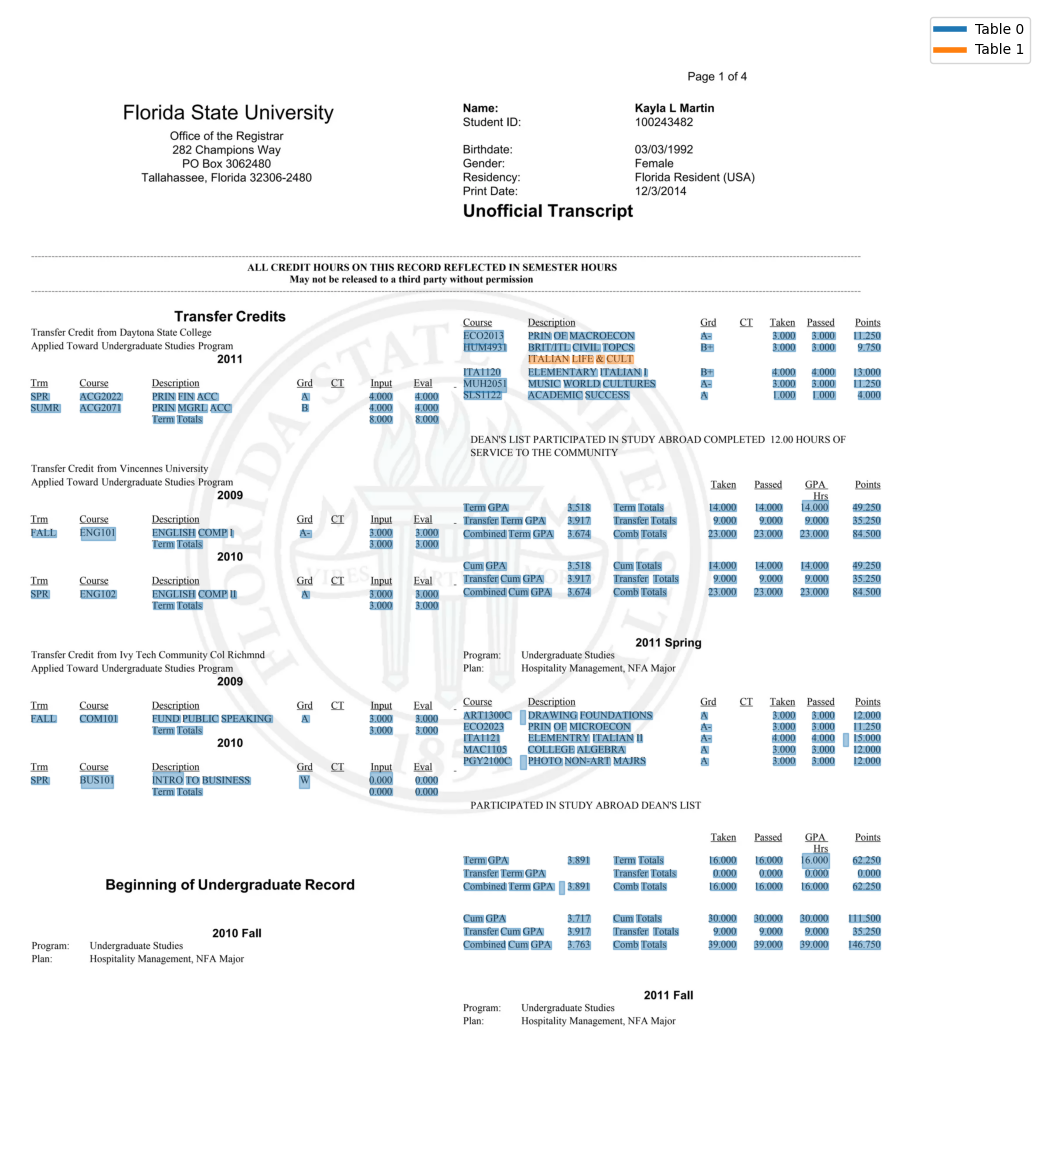

In [23]:
image = image_processor.image
row_classifier.plot_global_bounding_boxes(grouped_data, image)

In [86]:
# Combine clusters using translational Invariance:
# This step will combine clusters on the page by taking the widest cluster length,
# and then applying it as a reference dimension upon which all other clusters will project their lines
# The result is an integer heatmap for each cluster, all of which are the same length as the reference dimension
# and all of whom 'start' at the start of the leftmost bounding box in that cluster.

# similarity_threshold=0.00037
# regrouped_data = row_classifier.recombine_clusters_with_reference(grouped_data,  num_bins=1000, similarity_threshold=0.0001)

# print("\nNumber of Initial Clusters:", len(set(labels)))
# print("Number of Clusters Post-Adjustment:", len(regrouped_data))
# print(distance_matrix)

# """
# Silhouette Score: -0.09234253982312668
# Davies-Bouldin Index: 4.457894938875905
# Calinski-Harabasz Index: 2.6471638880885946
# """

# """
# Silhouette Score: 0.022071157365913408
# Davies-Bouldin Index: 7.3634520282939775
# Calinski-Harabasz Index: 2.3872250652264997
# """


INITIAL CLUSTERING METRICS

Silhouette Score: -0.26734627074940825
Davies-Bouldin Index: 10.752115324883565
Calinski-Harabasz Index: 1.9428347355716118

CLUSTERING METRICS AFTER REGROUPING

Silhouette Score: -0.2575335311868012
Davies-Bouldin Index: 4.104107324681775
Calinski-Harabasz Index: 2.747053357655891

Number of Initial Clusters: 14
Number of Clusters Post-Adjustment: 10


In [6]:
# image = image_processor.image
# row_classifier.plot_global_bounding_boxes(regrouped_data, image)